In [232]:
import wandb
import datetime
import argparse
import numpy as np
from train_and_test import train_and_test
from helpers import get_NWP_data,get_rain_gauge_or_radar_data, sw_func, find_experiment_directory, make_name_string
from models.lstm_regression import lstm_regression
from evaluator import only_MSE_and_GSS
from tensorflow import device
import sys

# Fixed paramters
project = "Thesis Experiment"
d_start = datetime.datetime(2015, 1, 1)
d_end = datetime.datetime(2019, 12, 31, 23, 59, 59)
max_lag = 24
pred_dist = 60
t_roll = 24
threshold_dict = {
    "RVK-GEL": [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
    "RVK-BOD": [0, 15,  30,  45,  60,  75,  90,  105, 120, 135, 150],
}
thresholds = np.array(list(threshold_dict.values()))
temperature_name = "1475_T"

# Cross-validation settings
fn_kfold = "TimeSeriesSplit"
folds = 5

# District heating model settings
cross_validation = {
    "fn_kfold": fn_kfold,
    "folds": folds,
}


# data_directory = (
#     "C:/Users/sverrirhd/Google Drive/Skóli/DTU/Thesis/Programming/Experiments/Data/"
# )

# save_dir = 'C:/Users/sverrirhd/model results/'

experiment_dir = find_experiment_directory()
data_directory = f"{experiment_dir}/Data/"
save_dir = f"{experiment_dir}/predictions/"

early_stopper_params = {
    'monitor': 'val_loss',
    'min_delta': 0,
    'patience': 20,
    'verbose': 0,
    'mode': 'min',
    'baseline': None,
    'restore_best_weights': True,
    }



In [404]:
parser = argparse.ArgumentParser()

# wandb.login()
config_lstm = {
    "name": "LSTM regression",
    "cross_validation": cross_validation,
    "thresholds": thresholds,
    'early_stopper': early_stopper_params,
    
    'lr_inital_log': -1,
    'lr_final_log': -4,
    'lr_intervals': 100,
    'batch_size': 128,
    'epochs': 120,
    'random_seed':0,
    'pred_dist':pred_dist,
    
    'eval_forecast_start': 24,
    'eval_forecast_end':30,
}

# Paramters
parser.add_argument(
    "-a",
    "--alpha",
    type=float,
    default=0,
    metavar="alpha",
    help="Regularization parameter for linear models (default: 0)",
)

# Paramters
parser.add_argument(
    "-u",
    "--units",
    type=int,
    default=10,
    metavar="units",
    help="Number of LSTM units to use (default: 10)",
)

# Paramters
parser.add_argument(
    "-o",
    "--obs",
    type=int,
    default=1,
    metavar="obs",
    help="number of observations to use (default: 1)",
)

parser.add_argument(
    "-i",
    "--include",
    type=str,
    default="r",
    metavar="include",
    help='which variables to use in the model (Options: "r", "rt", "rth")',
)

# datasource
parser.add_argument(
    "-d",
    "--datasource",
    type=str,
    default="NWP",
    metavar="datasource",
    help='Which data source to use (Options: "NWP", "raingauge", "radar")',
)

parser.add_argument(
    "-w",
    "--weights",
    type=str,
    default='a',
    metavar="weights",
    help='how to weigth the different samples (Options: "a", "b")',
)

# Paramters
parser.add_argument(
    "-l",
    "--lr_inital_log",
    type=float,
    default=-1,
    metavar="lr_inital_log",
    help="Initial log of learning rate (default: 0)",
)

# Paramters
parser.add_argument(
    "-L",
    "--lr_final_log",
    type=float,
    default=-4,
    metavar="lr_final_log",
    help="Change in log of learning rate (default: -4)",
)

# Paramters
parser.add_argument(
    "-b",
    "--batch_size",
    type=int,
    default=128,
    metavar="batch_size",
    help="batch_size",
)


# args = parser.parse_args()
fake_args = [
            '--alpha','0',
             '--units', '5',
             '--obs','24',
             '--include','rth',
             '--datasource','radar',
             '--w','a',
             '--lr_inital_log','-1',
             '--lr_final_log','-1',
             '--batch_size','128',
             ]
# 


In [405]:
args = parser.parse_args(fake_args)

In [406]:
if type(args.obs) == int:
    n_obs = args.obs
else:
    parser.print_help()
    sys.exit(1)
    
    
# Data source argument
if args.datasource == "NWP":
    X1, X2, X3, Y12 = get_NWP_data(threshold_dict,temperature_name,
                                    max_lag,pred_dist,d_start,d_end,
                                #    URL_save_data=data_directory
                                    )
    rain_shape = (-1, pred_dist, 100)
    temp_shape = (-1, pred_dist, 1)
    patt_shape = (-1, pred_dist, 24)
elif args.datasource == "radar":
    pred_dist_tmp = 1
    X1,_,X2,X3,Y12 = get_rain_gauge_or_radar_data(
        threshold_dict,
        temperature_name,
        n_obs,
        d_start,d_end,
        # URL_save_data=data_directory
        )
    rain_shape = (-1, n_obs, 20*20)
    temp_shape = (-1, n_obs, 1)
    patt_shape = (-1, n_obs, 24)
elif args.datasource == "gauge":
    pred_dist_tmp = 1
    _,X1,X2,X3,Y12 = get_rain_gauge_or_radar_data(
        threshold_dict,
        temperature_name,
        n_obs,
        d_start,d_end,
        # URL_save_data=data_directory
        )
    rain_shape = (-1, n_obs, 1)
    temp_shape = (-1, n_obs, 1)
    patt_shape = (-1, n_obs, 24)

# Rainfall argument
if args.include == "r":
    input_data = [X1.reshape(rain_shape)]
elif args.include == "rt":
    input_data = [
        X1.reshape(rain_shape),
        X2.reshape(temp_shape)
        ]
elif args.include == "rth":
    input_data = [
        X1.reshape(rain_shape),
        X2.reshape(temp_shape),
        X3.reshape(patt_shape),
    ]
else:
    parser.print_help()
    sys.exit(1)


if args.weights == "a":
    relative_weights = [1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]
    sample_weights_function = lambda x : sw_func(x, thresholds, relative_weights)
elif args.weights == "b":
    relative_weights = [0.5, 1, 1.5, 2,4,6,8,10,12,15,20]
    sample_weights_function = lambda x : sw_func(x, thresholds, relative_weights)
else:
    parser.print_help()
    sys.exit(1)
    
    
config_lstm.update(vars(args))
# run = wandb.init(config=config_lstm, project = project)
# config_lstm = wandb.config


In [414]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Input,TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow import random, losses
from tensorflow.keras.callbacks import LearningRateScheduler,EarlyStopping
from tensorflow import device
from tensorflow.keras.regularizers import l2
import numpy as np


class lstm_regression():
    def __init__(self, config,  **kwargs):
        self.config = config
        random.set_seed(self.config['random_seed'])
        
        self.model1 = self.construct_model()
        self.model2 = self.construct_model()
        self.model = self.parallelize(self.model1,self.model2)
        
        self.optimizer = Adam()
        self.model.compile(optimizer=self.optimizer,
                           loss=losses.MSE)
        
        self.lr_scheduler = LearningRateScheduler(self.lr_schedule, verbose=0)
        self.early_stopper = EarlyStopping(**config['early_stopper'])
        self.keywordarguments = {
            'epochs' : config['epochs'],
            'batch_size' : config['batch_size'],
            'shuffle' : True,
            'callbacks' : [
                self.lr_scheduler,
                self.early_stopper
                ],
        }
    def parallelize(self,m1,m2):
        inp = Input(m1.input_shape[1:])
        outp_1 = m1(inp)
        outp_2 = m2(inp)
        outp_con = Concatenate()([outp_1,outp_2])
        combined_model = Model(inp,outp_con)
        return combined_model

    def construct_model(self):
        config = self.config
        
        if config['datasource'] == 'NWP':
            if config['include'] == 'r':
                p = 100
            elif config['include'] == 'rt':
                p = 101
            elif config['include'] == 'rth':
                p = 125
            pred_dist_tmp = config['pred_dist']
            
                
        else:

            if config['datasource'] == 'radar':
                if config['include'] == 'r':
                    p = 400
                elif config['include'] == 'rt':
                    p = 401
                elif config['include'] == 'rth':
                    p = 425
                pred_dist_tmp = 1
            elif config['datasource'] == 'gauge':
                if config['include'] == 'r':
                    p = 1
                elif config['include'] == 'rt':
                    p = 2
                elif config['include'] == 'rth':
                    p = 26
                pred_dist_tmp = 1   
        
        model = Sequential([
            Input((self.config['obs'],p)),
            LSTM(units = self.config['units'], dropout = 0.05),
            Dense(1,activation='linear'),])
            
        return model
        
    def lr_schedule(self, epoch, lr):
        learning_rates = np.logspace(self.config['lr_inital_log'],
                                    self.config['lr_final_log'],
                                    self.config['lr_intervals'])
        epochs = self.config['epochs']
        return learning_rates[int(epoch/epochs * self.config['lr_intervals'])]
    
    def __combine_if_needed(self,X):
        '''
        Description:
        -----
        if the input is a list, it combines the inputs into a single array 
            with the same shape except the last dim
        '''
        X_new = X.copy()
        if type(X) == list:
            original_shapes = [i.shape for i in X_new]
            X_new = np.concatenate(X,axis=-1)
        else:
            original_shapes = X.shape
        
        return X_new,original_shapes

    def __restore_original_shape(self, X,original_shapes, flat_shape):
        if type(original_shapes) == list:
            first_shape = original_shapes[0].shape
            return_vectors = []
            if len(first_shape) == 2:
                used_p = 0
                for n,p in original_shapes:
                    return_vectors.append(X[:,used_p:used_p+p])
                    used_p = used_p + p
                return return_vectors
        else:
            return X.reshape((-1,*original_shapes[1:]))
        

    def __padded_windows(self,X):
        '''
        Pad the first observations with zeros so the model can get a sliding window with all available data
        --------
        example: obs = 3
          before: [x1, x2, x3]
          after: [[0,0,x1],[0,x1,x2],[x1,x2,x3]]
        '''
        
        X_padded = np.concatenate([
            np.zeros((X.shape[0],
                      self.config['obs']-1,
                      X.shape[-1])),
            X],axis=1)
        window_shape = (1,self.config['obs'],X_padded.shape[-1])
        X_seq = np.lib.stride_tricks.sliding_window_view(
            X_padded,
            window_shape).squeeze()
        return X_seq
    
    def fit(self, fold_data, weight_func):
        '''
        
        X.shape : (n_batch, n_observations, n_variables)
        Y.shape : (n_batch x n_sensors)
        '''
        X = fold_data['X_train']
        Y = fold_data['Y_train'] 
        X_val = fold_data['X_val']
        Y_val = fold_data['Y_val'] 
        if type(X) == list:
            for i in X:
                assert i.ndim == 3
        else:
            assert X.ndim == 3
            
        X_new, original_shape_X = self.__combine_if_needed(X)
        Y_new, original_shape_Y = self.__combine_if_needed(Y)
        
        X_val_new, _ = self.__combine_if_needed(X_val)
        Y_val_new, _ = self.__combine_if_needed(Y_val)
        
        self.original_shape_X = original_shape_X
        self.original_shape_Y = original_shape_Y
        
        fold_data['sample_weights'] = weight_func(Y)
        self.y_dim = Y_new.ndim
        verbose = 1
        if self.y_dim == 3:
            n1,f,p = X_new.shape
            n2,*_= X_val_new.shape
            X_new_seq = self.__padded_windows(X_new)
            X_val_new_seq = self.__padded_windows(X_val_new)
            
            X_new_seq = X_new_seq.reshape((n1,f,-1,p))
            X_val_new_seq = X_val_new_seq.reshape((n2,f,-1,p))
            
            self.model.fit(
                X_new_seq,
                Y_new,
                validation_data = (X_val_new_seq,Y_val_new),
                sample_weight=fold_data['sample_weights'],
                verbose = verbose,
                **self.keywordarguments,)
            
            
        elif self.y_dim == 2:
            self.model.fit(
                X_new,
                Y_new,
                validation_data = (X_val_new,Y_val_new),
                sample_weight=fold_data['sample_weights'],
                verbose = verbose,
                **self.keywordarguments)

    def predict(self, X):
        
        X_new, *_ = self.__combine_if_needed(X)
        if self.y_dim == 3:
            n,f,p = X_new.shape
            X_new_seq = self.__padded_windows(X_new)
            X_new_seq = X_new_seq.reshape((n,f,-1,p))
            Y_pred1 = self.model1.predict(X_new_seq)
            Y_pred2 = self.model2.predict(X_new_seq)
            Y_pred = np.concatenate([Y_pred1.reshape(len(X_new_seq,-1,1)),
                                    Y_pred2.reshape(len(X_new_seq,-1,1))],axis=-1)
        else:
            Y_pred1 = self.model1.predict(X_new)
            Y_pred2 = self.model2.predict(X_new)
            Y_pred = np.concatenate([Y_pred1.reshape((len(X_new),1)),
                                    Y_pred2.reshape((len(X_new),1))],axis=-1)
            
            # Y_pred = self.model.predict(X_new)
        # Y_pred_restored = self.__restore_original_shape(Y_pred,self.original_shape_Y,self.original_shape_Y)
        return Y_pred#.reshape(-1,60,2)

    

In [415]:
instance = lstm_regression(config_lstm)
model_tmp = instance.model

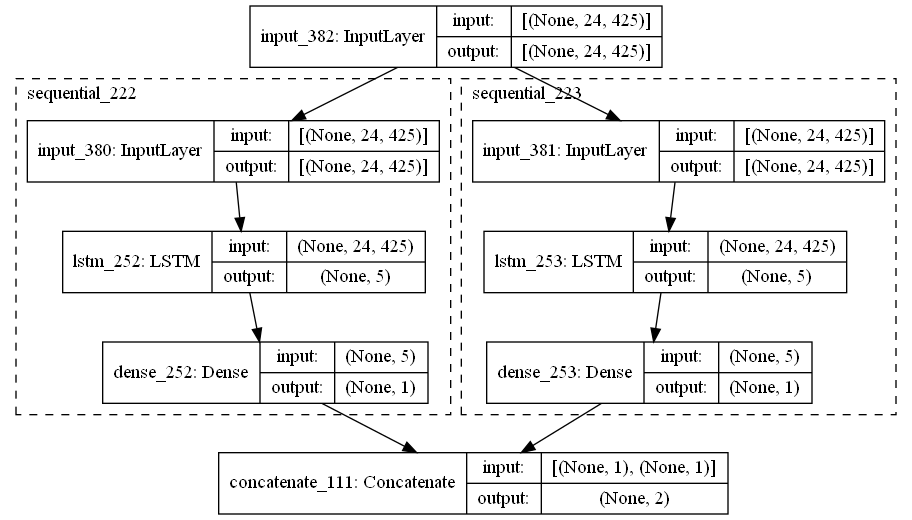

In [416]:
from tensorflow.keras.layers import *
from tensorflow.keras import Model

plot_model(model_tmp,expand_nested=True,show_shapes=True)

In [417]:
lstm_regression_constructor = lambda : lstm_regression(config_lstm)

# CPU: ~12.5 min (batch size 32)
# Mætti prófa að hækka batches eftir að ég lagaði
#   lögunina á outputtinu - sem olli n**2 samanburðum 
#   þá keyrir þetta á <5min)
with device('cpu:0'):
    recurrent_results = train_and_test(
        model_constructor=lstm_regression_constructor,
        input_data=input_data,
        # input_data=input_data,
        output_data=Y12,
        weight_func=sample_weights_function,
        config=config_lstm,
    )

Epoch 1/120
52/52 [==============================] - 8s 61ms/step - loss: 31281.1562 - val_loss: 20320.2715
Epoch 2/120
52/52 [==============================] - 2s 35ms/step - loss: 24335.0918 - val_loss: 15892.8525
Epoch 3/120
52/52 [==============================] - 2s 34ms/step - loss: 19642.4473 - val_loss: 12904.9473
Epoch 4/120
52/52 [==============================] - 2s 36ms/step - loss: 16323.8369 - val_loss: 10829.3711
Epoch 5/120
52/52 [==============================] - 2s 36ms/step - loss: 13947.2734 - val_loss: 9426.5635
Epoch 6/120
52/52 [==============================] - 2s 37ms/step - loss: 12279.5732 - val_loss: 8538.8438
Epoch 7/120
52/52 [==============================] - 2s 36ms/step - loss: 11142.4707 - val_loss: 8036.1040
Epoch 8/120
52/52 [==============================] - 2s 35ms/step - loss: 10399.3271 - val_loss: 7788.6938
Epoch 9/120
52/52 [==============================] - 2s 38ms/step - loss: 9930.2910 - val_loss: 7700.9971
Epoch 10/120
52/52 [==============

In [418]:
recurrent_results["iop"][0]['Y_val_pred'].shape

(6641, 2)

In [419]:
minimum_eval_dict = only_MSE_and_GSS(recurrent_results["iop"],sample_weights_function,config_lstm)

In [420]:
minimum_eval_dict

{'folds': {},
 'summary': {'total_mean_squared_error': 4269.7082504329765,
  'total_mean_absolute_error': 32.78365365248935,
  'total_weighted_mean_squared_error': 4269.7082504329765,
  'total_weighted_mean_absolute_error': 32.78365365248935,
  'GSS_val_0': 0.24835726537786323,
  'GSS_val_1': 0.14694547534759836,
  'GSS_val_average': 0.19765137036273078}}

In [ ]:

# file_name = f'recurrent_model_{args.weights}_{args.datasource}_{args.include}_{args.units}_{args.obs}'

# args_dict = vars(args)
# file_name = make_name_string('LSTM',args_dict)
# np.save(save_dir + file_name,recurrent_results['iop'], allow_pickle=True)

# Minimal logging for model selection
# minimum_eval_dict = only_MSE_and_GSS(recurrent_results["iop"],sample_weights_function,config_lstm)
# wandb.log(minimum_eval_dict['summary'])
# run.finish()
    
